In [1]:
import random
import string
from datetime import datetime, timedelta
import psycopg2
from psycopg2 import sql
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.ticker as mtick  # Importa el módulo para formatear el eje
import re # Expresiones regulares
from IPython.display import display


In [2]:
# ------------ FUNCIONES ----------------

# 1. Conexión con BD
# 1.1 Con PSYCOPG2
def conexionBDPostgresSQL():
    # Se omiten los datos de conexión.
    conexion = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="serRIB99",
        host="localhost",
        port="5432"
    )
    return conexion



# 0.
def obtenerDatosBBDD(comandoSQL):
    # Crear conexión y obtener cursor
    conexionBD = conexionBDPostgresSQL() #conexionBDPostgresSQL()
    cursor = conexionBD.cursor()

    # Ejecutar comando y obtener datos
    cursor.execute(comandoSQL)
    registros = cursor.fetchall()

    # Obtener columnas desde el cursor
    columnas = [desc[0] for desc in cursor.description]
    cursor.close()
    conexionBD.close()
    return registros, columnas


# 1. Obtener datos emisiones (procesados)
def obtenerDataframeemisiones():
  comandoSQL_emisiones = "SELECT * FROM tfm.emisiones_procesada ORDER BY \"fecha\" ASC"
  datosemisiones, columnasemisiones =  obtenerDatosBBDD(comandoSQL_emisiones)
  df_emisiones = pd.DataFrame(datosemisiones, columns=columnasemisiones)
  return df_emisiones


def visualizarDiagramaBarrasPorAnyo(dataset, columnas):
    # Creamos un nuevo dataframe para sumar los valores por año
    dataset_agregado = dataset.copy()
    dataset_agregado['fecha'] = pd.to_datetime(dataset_agregado['fecha'])
    dataset_agregado['año'] = dataset_agregado['fecha'].dt.year
    dataset_agregado = dataset_agregado.groupby('año')[columnas].sum().reset_index()

    # Definimos el número de filas y columnas para los subplots
    if(len(columnas)==1):
        n_col = 1
    else:
        n_col = 2
    n_row = (len(columnas) + 1) // n_col

    fig, axes = plt.subplots(n_row, n_col, figsize=(15, 5 * n_row))

    # Ajustamos el layout para evitar solapamientos
    fig.tight_layout(pad=5.0)

    # Generamos los diagramas de barras para cada columna
    for idx, columna in enumerate(columnas):
        row = idx // n_col
        col = idx % n_col
        ax = axes[row, col]
        ax.bar(dataset_agregado['año'], dataset_agregado[columna], color='blue')
        ax.set_xlabel('Año')
        ax.set_ylabel('emisiones (MWh)')
        ax.set_title(f'emisiones anual de {columna} (Acumulado)')
        ax.set_xticks(dataset_agregado['año'])
        ax.set_xticklabels(dataset_agregado['año'], rotation=45)

        # Deshabilitamos la notación científica en el eje y
        ax.get_yaxis().set_major_formatter(mtick.ScalarFormatter())
        ax.get_yaxis().get_major_formatter().set_useOffset(False)
        ax.get_yaxis().get_major_formatter().set_scientific(False)

    # Si el número de columnas es impar, eliminamos el subplot vacío
    if len(columnas) % n_col != 0:
        fig.delaxes(axes[-1, -1])

    plt.show()

def crearColumnasAnyoMesDia(dataset):
  # Crear nuevas columnas
  dataset['Año'] = dataset['fecha'].dt.year
  dataset['Mes'] = dataset['fecha'].dt.month
  dataset['Dia'] = dataset['fecha'].dt.day
  dataset['DiaSemana'] = dataset['fecha'].dt.weekday + 1  # +1 para que 1=Lunes, ..., 7=Domingo
  return dataset




def visualizarDiagramaBarrasPorAnyo_Media(dataset, columnas):
  # Creamos un nuevo dataframe para sumar los valores por año
  dataset_agregado = dataset.copy()
  dataset_agregado['fecha'] = pd.to_datetime(dataset_agregado['fecha'])
  dataset_agregado['año'] = dataset_agregado['fecha'].dt.year
  dataset_agregado = dataset_agregado.groupby('año')[columnas].mean().reset_index()

  # Definimos el número de filas y columnas para los subplots
  if(len(columnas)==1):
      n_col = 1
  else:
      n_col = 2
  n_row = (len(columnas) + 1) // n_col

  fig, axes = plt.subplots(n_row, n_col, figsize=(15, 5 * n_row))

  # Ajustamos el layout para evitar solapamientos
  fig.tight_layout(pad=5.0)

  # Generamos los diagramas de barras para cada columna
  for idx, columna in enumerate(columnas):
      row = idx // n_col
      col = idx % n_col
      ax = axes[row, col]
      ax.bar(dataset_agregado['año'], dataset_agregado[columna], color='blue')
      ax.set_xlabel('Año')
      ax.set_ylabel('emisiones (MWh)')
      ax.set_title(f'emisiones anual media de {columna}')
      ax.set_xticks(dataset_agregado['año'])
      ax.set_xticklabels(dataset_agregado['año'], rotation=45)

      # Deshabilitamos la notación científica en el eje y
      ax.get_yaxis().set_major_formatter(mtick.ScalarFormatter())
      ax.get_yaxis().get_major_formatter().set_useOffset(False)
      ax.get_yaxis().get_major_formatter().set_scientific(False)

  # Si el número de columnas es impar, eliminamos el subplot vacío
  if len(columnas) % n_col != 0:
      fig.delaxes(axes[-1, -1])

  plt.show()



def generarGraficasDistribucion_2filas_gen(dataset,fecha,mes,dia_semana,columna):

    diccionarioMeses = {
        1: 'Enero',
        2: 'Febrero',
        3: 'Marzo',
        4: 'Abril',
        5: 'Mayo',
        6: 'Junio',
        7: 'Julio',
        8: 'Agosto',
        9: 'Septiembre',
        10: 'Octubre',
        11: 'Noviembre',
        12: 'Diciembre'
    }
    diccionarioDiaSemana = {
        1: 'Lunes',
        2: 'Martes',
        3: 'Miércoles',
        4: 'Jueves',
        5: 'Viernes',
        6: 'Sábado',
        7: 'Domingo'
    }
    # Ajustar tamaño de la figura para 1 fila de 3 gráficos y 1 fila de 1 gráfico que ocupe todo el ancho
    fig = plt.figure(figsize=(15, 10), dpi=300)
    # Crear subplots manualmente
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
    ax3 = plt.subplot2grid((3, 3), (0, 2), colspan=1)
    ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=3, rowspan=1)  # Este eje ocupa toda la segunda fila
    
    # emisiones por día de la semana
    
    # Agrupar los datos por la columna especificada y calcular la media de los valores en esos grupos
    df_agrupado_dia = dataset.groupby(dia_semana)[columna].mean().reset_index()

    # Calcular la media global de la columna agrupada (después de agrupar)
    media_global = df_agrupado_dia[columna].mean()
    
    etiquetas_traducidas_dia = [diccionarioDiaSemana.get(label, label) for label in df_agrupado_dia[dia_semana]]

    # Crear el gráfico de barras
    bar_positions = range(len(df_agrupado_dia[columna]))
    ax1.bar(bar_positions, df_agrupado_dia[columna], color='lightcoral')

    # Añadir la línea de la media global de los valores agrupados
    ax1.axhline(y=media_global, color='red', linestyle='--', label=f'Valor medio: ({media_global:.2f})')
    # Reducir el tamaño de la leyenda
    ax1.legend(loc='upper right', framealpha=0.5, fontsize='small')


    # Añadir etiquetas y título
    #ax1.xlabel(columna_para_agrupar.capitalize())
    #ax1.ylabel('Valor emisiones media')
    ax1.set_title(f'Emisiones por día de la semana de: {columna.upper()}')

    # Configurar xticks manualmente para mostrar todas las etiquetas correctamente alineadas
    ax1.set_xticks(ticks=bar_positions, labels=etiquetas_traducidas_dia, rotation=45, ha='right')

    # emisiones por mes
    
    # Agrupar los datos por la columna especificada y calcular la media de los valores en esos grupos
    df_agrupado_mes = dataset.groupby(mes)[columna].mean().reset_index()

    # Calcular la media global de la columna agrupada (después de agrupar)
    media_global = df_agrupado_mes[columna].mean()

    # Crear el gráfico de barras
    bar_positions = range(len(df_agrupado_mes[columna]))
    ax2.bar(bar_positions, df_agrupado_mes[columna], color='khaki')

    # Añadir la línea de la media global de los valores agrupados
    ax2.axhline(y=media_global, color='red', linestyle='--', label=f'Valor medio: ({media_global:.2f})')
    # Reducir el tamaño de la leyenda
    ax2.legend(loc='upper right', framealpha=0.5, fontsize='small')

    etiquetas_traducidas_mes = [diccionarioMeses.get(label, label) for label in df_agrupado_mes[mes]]

    # Añadir etiquetas y título
    #ax2.xlabel(columna_para_agrupar.capitalize())
    #ax2.ylabel('Valor emisiones media')
    ax2.set_title(f'Emisiones por mes del año de: {columna.upper()}')

    # Configurar xticks manualmente para mostrar todas las etiquetas correctamente alineadas
    #plt.xticks(ticks=bar_positions, labels=etiquetas_traducidas, rotation=45, ha='right')


    # Histograma
    sns.histplot(dataset[columna], kde=True, ax=ax3,  color='paleturquoise')
    ax3.set_title(f'Histograma de: {columna.upper()}')
    #ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')
    #ax2.tick_params(axis='x', labelsize=8.5) # Sólo si se solapan los textos
    #ax2.set_ylabel('Etiqueta EJE Y')
    
    #Serie temportal

    if not pd.api.types.is_datetime64_any_dtype(dataset['fecha']):
        dataset['fecha'] = pd.to_datetime(dataset['fecha'])

    ax4.plot(dataset['fecha'], dataset[columna], linestyle='-', color='plum')
    ax4.set_title(f'Serie Temporal de: {columna.upper()}')
    ax4.set_xlabel('Fecha')
    ax4.set_ylabel('Valor')

    # Establecer el formato del eje x para mostrar cada año
    ax4.xaxis.set_major_locator(mdates.YearLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Añadir líneas verticales punteadas en cada año
    years = mdates.YearLocator()  # Localizador de años
    for year_loc in years.tick_values(dataset['fecha'].min(), dataset['fecha'].max()):
        ax4.axvline(x=year_loc, color='gray', linestyle='dashed', linewidth=1)

    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)  # Rotar las etiquetas si es necesario para mejor visualización
    
    # Use the pyplot interface to change just one subplot...
    
    plt.sca(ax2)
    plt.xticks(ticks=bar_positions, labels=etiquetas_traducidas_mes, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f'emisiones_{columna}.jpg')
    plt.show()



# Función para generar un gráfico de barras que comparar
def generarGraficaComparacion(dataframe, columna_fecha, columna_variable1, columna_variable2):
    # Convertir la columna de fecha a datetime si no lo está
    dataframe[columna_fecha] = pd.to_datetime(dataframe[columna_fecha])

    # Ordenar el DataFrame por la columna de fecha
    dataframe = dataframe.sort_values(by=columna_fecha)

    # Crear el gráfico de líneas
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe[columna_fecha], dataframe[columna_variable1], label=columna_variable1, marker='o')
    plt.plot(dataframe[columna_fecha], dataframe[columna_variable2], label=columna_variable2, marker='o')

    # Personalizar el gráfico
    plt.title(f'Evolución de {columna_variable1} y {columna_variable2} a lo largo del tiempo')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)

    # Rotar las etiquetas del eje x si es necesario
    plt.xticks(rotation=45)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()


def visualizarComparativa_Renovables_NoRenovables(df, columna_fecha, columna_variable1, columna_variable2):
    # Convertir la columna de fecha a datetime si no lo está
    df[columna_fecha] = pd.to_datetime(df[columna_fecha])

    # Establecer la columna de fecha como índice
    df.set_index(columna_fecha, inplace=True)

    # Resamplear los datos a frecuencia mensual y agregar (sumar) las variables
    df_mensual = df[[columna_variable1, columna_variable2]].resample('M').mean()

    # Crear el gráfico de líneas
    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(df_mensual.index, df_mensual[columna_variable1], label=columna_variable1, marker='', color='blue')
    plt.plot(df_mensual.index, df_mensual[columna_variable2], label=columna_variable2, marker='', color='green')

    # Personalizar el gráfico
    plt.title(f'Evolución {columna_variable1} y {columna_variable2}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)

    # Asegurar que todos los años aparezcan en el eje X
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Rotar las etiquetas del eje x si es necesario
    plt.xticks(rotation=45)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

"""Función que agrupa los datos de un DataFrame por una columna y calcula la media de los valores
de otra columna en esos grupos. Genera un gráfico de barras de las medias calculadas
asegurando que las etiquetas sean visibles, y añade una línea horizontal que representa
la media global de los valores agrupados."""

def visualizarDiagramaBarras_Media(dataframe,
                                   columna_para_agrupar,
                                   columna_a_agrupar,
                                   traducciones=None,
                                   descripcionDatos=''):

    # Agrupar los datos por la columna especificada y calcular la media de los valores en esos grupos
    df_agrupado = dataframe.groupby(columna_para_agrupar)[columna_a_agrupar].mean().reset_index()

    # Calcular la media global de la columna agrupada (después de agrupar)
    media_global = df_agrupado[columna_a_agrupar].mean()

    # Crear el gráfico de barras
    bar_positions = range(len(df_agrupado[columna_para_agrupar]))
    plt.bar(bar_positions, df_agrupado[columna_a_agrupar], color='skyblue')

    # Añadir la línea de la media global de los valores agrupados
    plt.axhline(y=media_global, color='red', linestyle='--', label=f'Valor medio: ({media_global:.2f})')
    # Reducir el tamaño de la leyenda
    plt.legend(loc='upper right', framealpha=0.5, fontsize='small')

    # Si se proporciona un diccionario de traducciones, traducir las etiquetas del eje X
    if traducciones:
        etiquetas_traducidas = [traducciones.get(label, label) for label in df_agrupado[columna_para_agrupar]]
    else:
        etiquetas_traducidas = df_agrupado[columna_para_agrupar]

    # Añadir etiquetas y título
    plt.xlabel(columna_para_agrupar.capitalize())
    plt.ylabel(f'Valor ({descripcionDatos} media)')
    plt.title(f'{descripcionDatos} media por {columna_para_agrupar}')

    # Configurar xticks manualmente para mostrar todas las etiquetas correctamente alineadas
    plt.xticks(ticks=bar_positions, labels=etiquetas_traducidas, rotation=45, ha='right')

    # Ajustar márgenes para que todas las etiquetas se vean correctamente
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

    return df_agrupado


def calcularCorrelacionMapaCalor(dataframe):
  # Calculamos la matriz de correlaciones
  correlation_matrix = dataframe.corr()
  # Mapa de calor
  plt.figure(figsize=(10, 8), dpi=300)  # Ajusta el tamaño si lo necesitas
  sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
  plt.show()



# Calcula el factor de capacidad de emisiones (FCG) para cada tipo de energía renovable.
def CalcularFactorCapacidadEnergia(dataframe, columnas_emisiones, columnas_potencia_instalada, periodo_horas=24):
    for emisiones_col in columnas_emisiones:
        # Buscar la columna de potencia instalada correspondiente
        potencia_col = None
        for potencia in columnas_potencia_instalada:
            if potencia.replace("PI_", "") in emisiones_col:
                potencia_col = potencia
                break

        if potencia_col is not None:
            # Calcular el factor de capacidad
            fcg_col_name = "FCG_" + emisiones_col
            dataframe[fcg_col_name] = dataframe[emisiones_col] / (dataframe[potencia_col] * periodo_horas)
        else:
            print(f"No se encontró una columna de potencia instalada correspondiente para {emisiones_col}")

    return dataframe

## emisiones
Ahora que ya hemos creado todas las funciones que vamos a usar en este análisis, vamos a importar los datos a un dataframe y empezar a trabajar con ellos.

In [4]:
# 1. emisiones
dataframeemisiones = obtenerDataframeemisiones()
# Asegurar que todos los dataframe tiene un campo llamado "fecha"
dataframeemisiones = dataframeemisiones.rename(columns={'fechaemisiones': 'fecha'})
dataframeemisiones.dtypes

fecha              datetime64[ns]
carbon                     object
ciclocombinado             object
cogeneracion                int64
fuelgas                    object
motordiesel                object
turbinagas                 object
turbinavapor               object
residuosnorenov            object
emisionestotal             object
emisionespormwh            object
dtype: object

Como los tipos de datos importados desde la tabla de PostgreSQLno estan bien, es necesario transformar la columna valor demanda a valor numérico

In [6]:
columnas_numericas = ["carbon",
                      "ciclocombinado",
                      "cogeneracion",
                      "fuelgas",
                      "motordiesel",
                      "turbinagas",
                      "turbinavapor",
                      "residuosnorenov",
                      "emisionestotal",
                      "emisionespormwh"]
dataframeemisiones[columnas_numericas] = dataframeemisiones[columnas_numericas].apply(pd.to_numeric, errors='coerce')
dataframeemisiones.dtypes

fecha              datetime64[ns]
carbon                    float64
ciclocombinado            float64
cogeneracion                int64
fuelgas                   float64
motordiesel               float64
turbinagas                float64
turbinavapor              float64
residuosnorenov           float64
emisionestotal            float64
emisionespormwh           float64
dtype: object

Ahora que ya hemos ajustado los tipos de datos vamos, vamos a usar la función describe para ver un resumen de los datos del dataframe

In [8]:
dataframeemisiones.describe(include='all')

fecha         carbon  ciclocombinado  cogeneracion  \
count                 5114    5114.000000     5114.000000        5114.0   
mean   2017-12-31 12:00:00   70710.730295    43895.818539           0.0   
min    2011-01-01 00:00:00       0.000000    10760.109000           0.0   
25%    2014-07-02 06:00:00   10437.435500    26817.702500           0.0   
50%    2017-12-31 12:00:00   47304.981000    37215.734000           0.0   
75%    2021-07-01 18:00:00  130733.492250    56240.286000           0.0   
max    2024-12-31 00:00:00  226270.304000   150182.113000           0.0   
std                    NaN   64960.416655    22833.240946           0.0   

           fuelgas  motordiesel   turbinagas  turbinavapor  residuosnorenov  \
count  5114.000000  5114.000000  5114.000000   5114.000000      5114.000000   
mean      0.164822  6265.752596  1990.571370   4911.225449      1431.156121   
min       0.000000  3176.245000   104.502000    530.626000       274.960000   
25%       0.000000  4932.930750  1319.299000   3370.490500      1017.738000   
50%       0.000000  6520.552500  1882.108000   5172.949000      1418.865000   
75%       0.000000  7476.514250  2560.441250   6349.912000      1782.961250   
max      48.469000  9611.469000  5314.851000   8473.671000      2507.683000   
std       1.791094  1471.014003   917.293957   1702.652110       480.610294   

       emisionestotal  emisionespormwh  
count     5114.000000      5114.000000  
mean    157686.638534         0.216590  
min      42932.844000         0.056991  
25%      96356.198250         0.139280  
50%     140973.366500         0.200411  
75%     217949.162750         0.299831  
max     366213.972000         0.425601  
std      72236.815327         0.091958

En este caso vemos que hay columnas que no nos aportam mucha información, como la coemisiones o el fuel y gas, que tiene valore de 0 siempre o casi siempre, por eso vamos a descartar esas dos columnas en el análisis visual de la tabla.

Veamos  ahora si el dataframe tiene las dimensiones esperadas.

In [10]:
print("Dimensiones: ", dataframeemisiones.shape)

Dimensiones:  (5114, 11)


Veamos ahora que no hay valores duplicados en nuestro dataset.

In [12]:
# Comprobar si hay duplicados
duplicados = dataframeemisiones.duplicated()

# Mostrar los registros duplicados (esto incluye la primera aparición)
df_duplicados = dataframeemisiones[duplicados]

# Mostrar el resultado
print("Registros duplicados:")
print(df_duplicados)

Registros duplicados:
Empty DataFrame
Columns: [fecha, carbon, ciclocombinado, cogeneracion, fuelgas, motordiesel, turbinagas, turbinavapor, residuosnorenov, emisionestotal, emisionespormwh]
Index: []


Por último, vamos a crear las columnas necesaria para los visuales, estas son las columnas de año, mes, dia y dia de la semana.

In [14]:
dataframeemisiones = crearColumnasAnyoMesDia(dataframeemisiones)
dataframeemisiones.head()

fecha      carbon  ciclocombinado  cogeneracion  fuelgas  motordiesel  \
0 2011-01-01   60383.610       56093.042             0      0.0     7868.698   
1 2011-01-02   60109.235       42428.998             0      0.0     8004.911   
2 2011-01-03   94407.316       84837.898             0      0.0     8365.888   
3 2011-01-04  109372.271       78843.807             0      0.0     8357.493   
4 2011-01-05   68354.036       44705.522             0      0.0     8398.663   

   turbinagas  turbinavapor  residuosnorenov  emisionestotal  emisionespormwh  \
0     608.304      5638.806          834.389      154243.218         0.247060   
1     793.377      6507.919          850.047      144533.993         0.212542   
2    2132.724      7610.614          864.455      232311.894         0.276871   
3    2356.721      7436.203          818.393      242568.461         0.280973   
4    1674.490      7328.523          835.749      165656.989         0.198794   

    Año  Mes  Dia  DiaSemana  
0  2011    1    1          6  
1  2011    1    2          7  
2  2011    1    3          1  
3  2011    1    4          2  
4  2011    1    5          3

Y podemos sacar ya los gráficos, vamos a obtener una gráfica por cada columna de emisiones de energía.

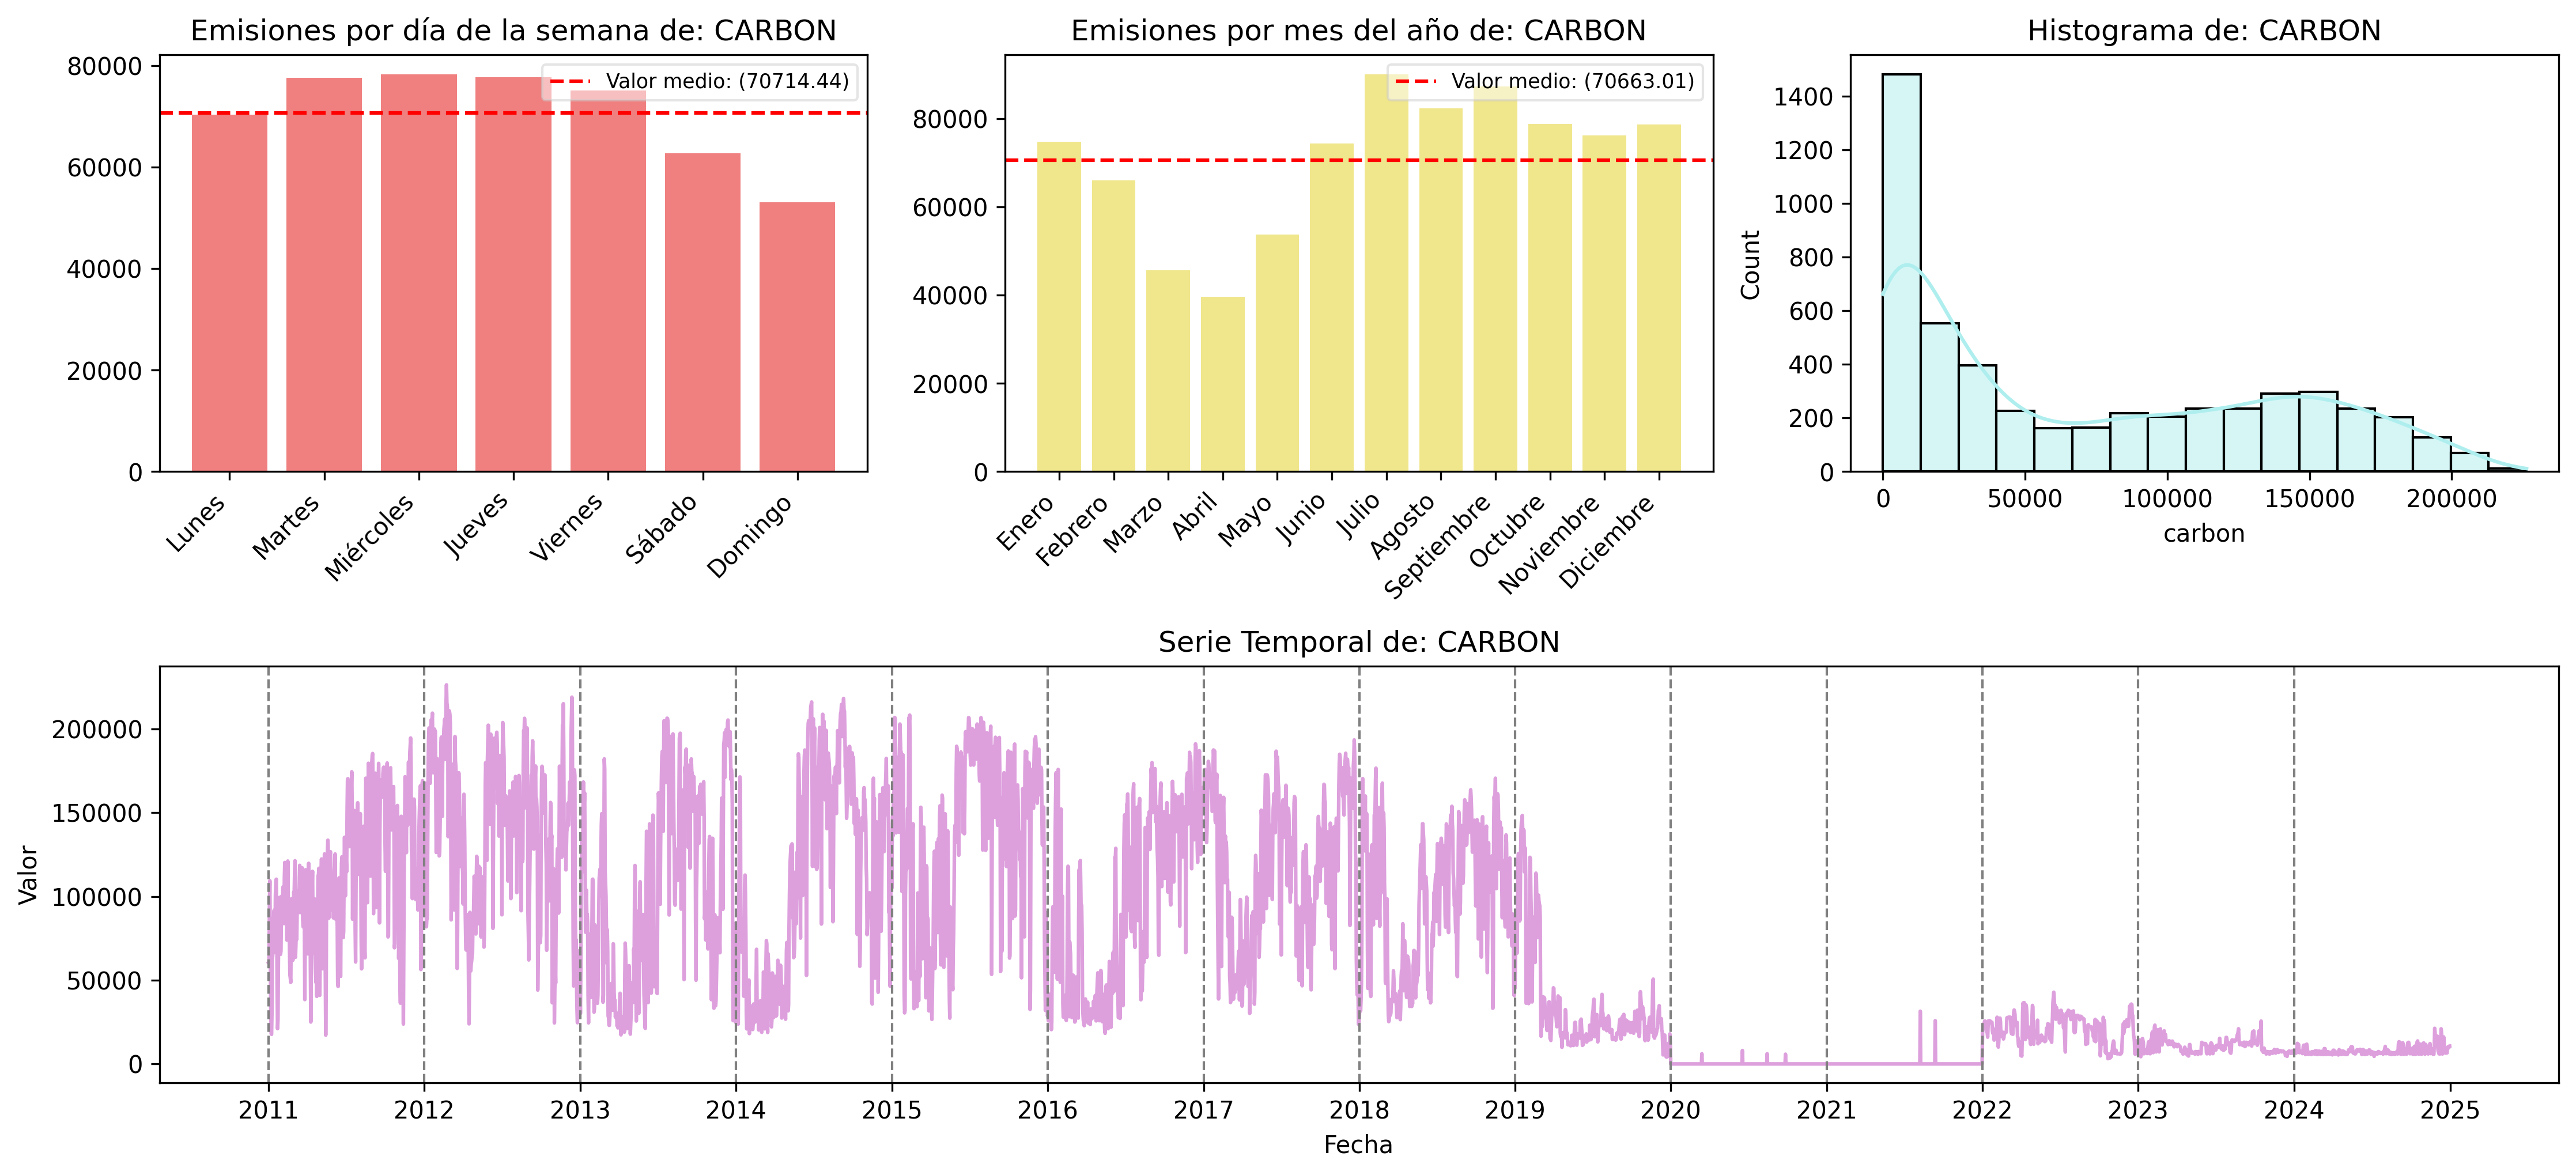

In [16]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','carbon')

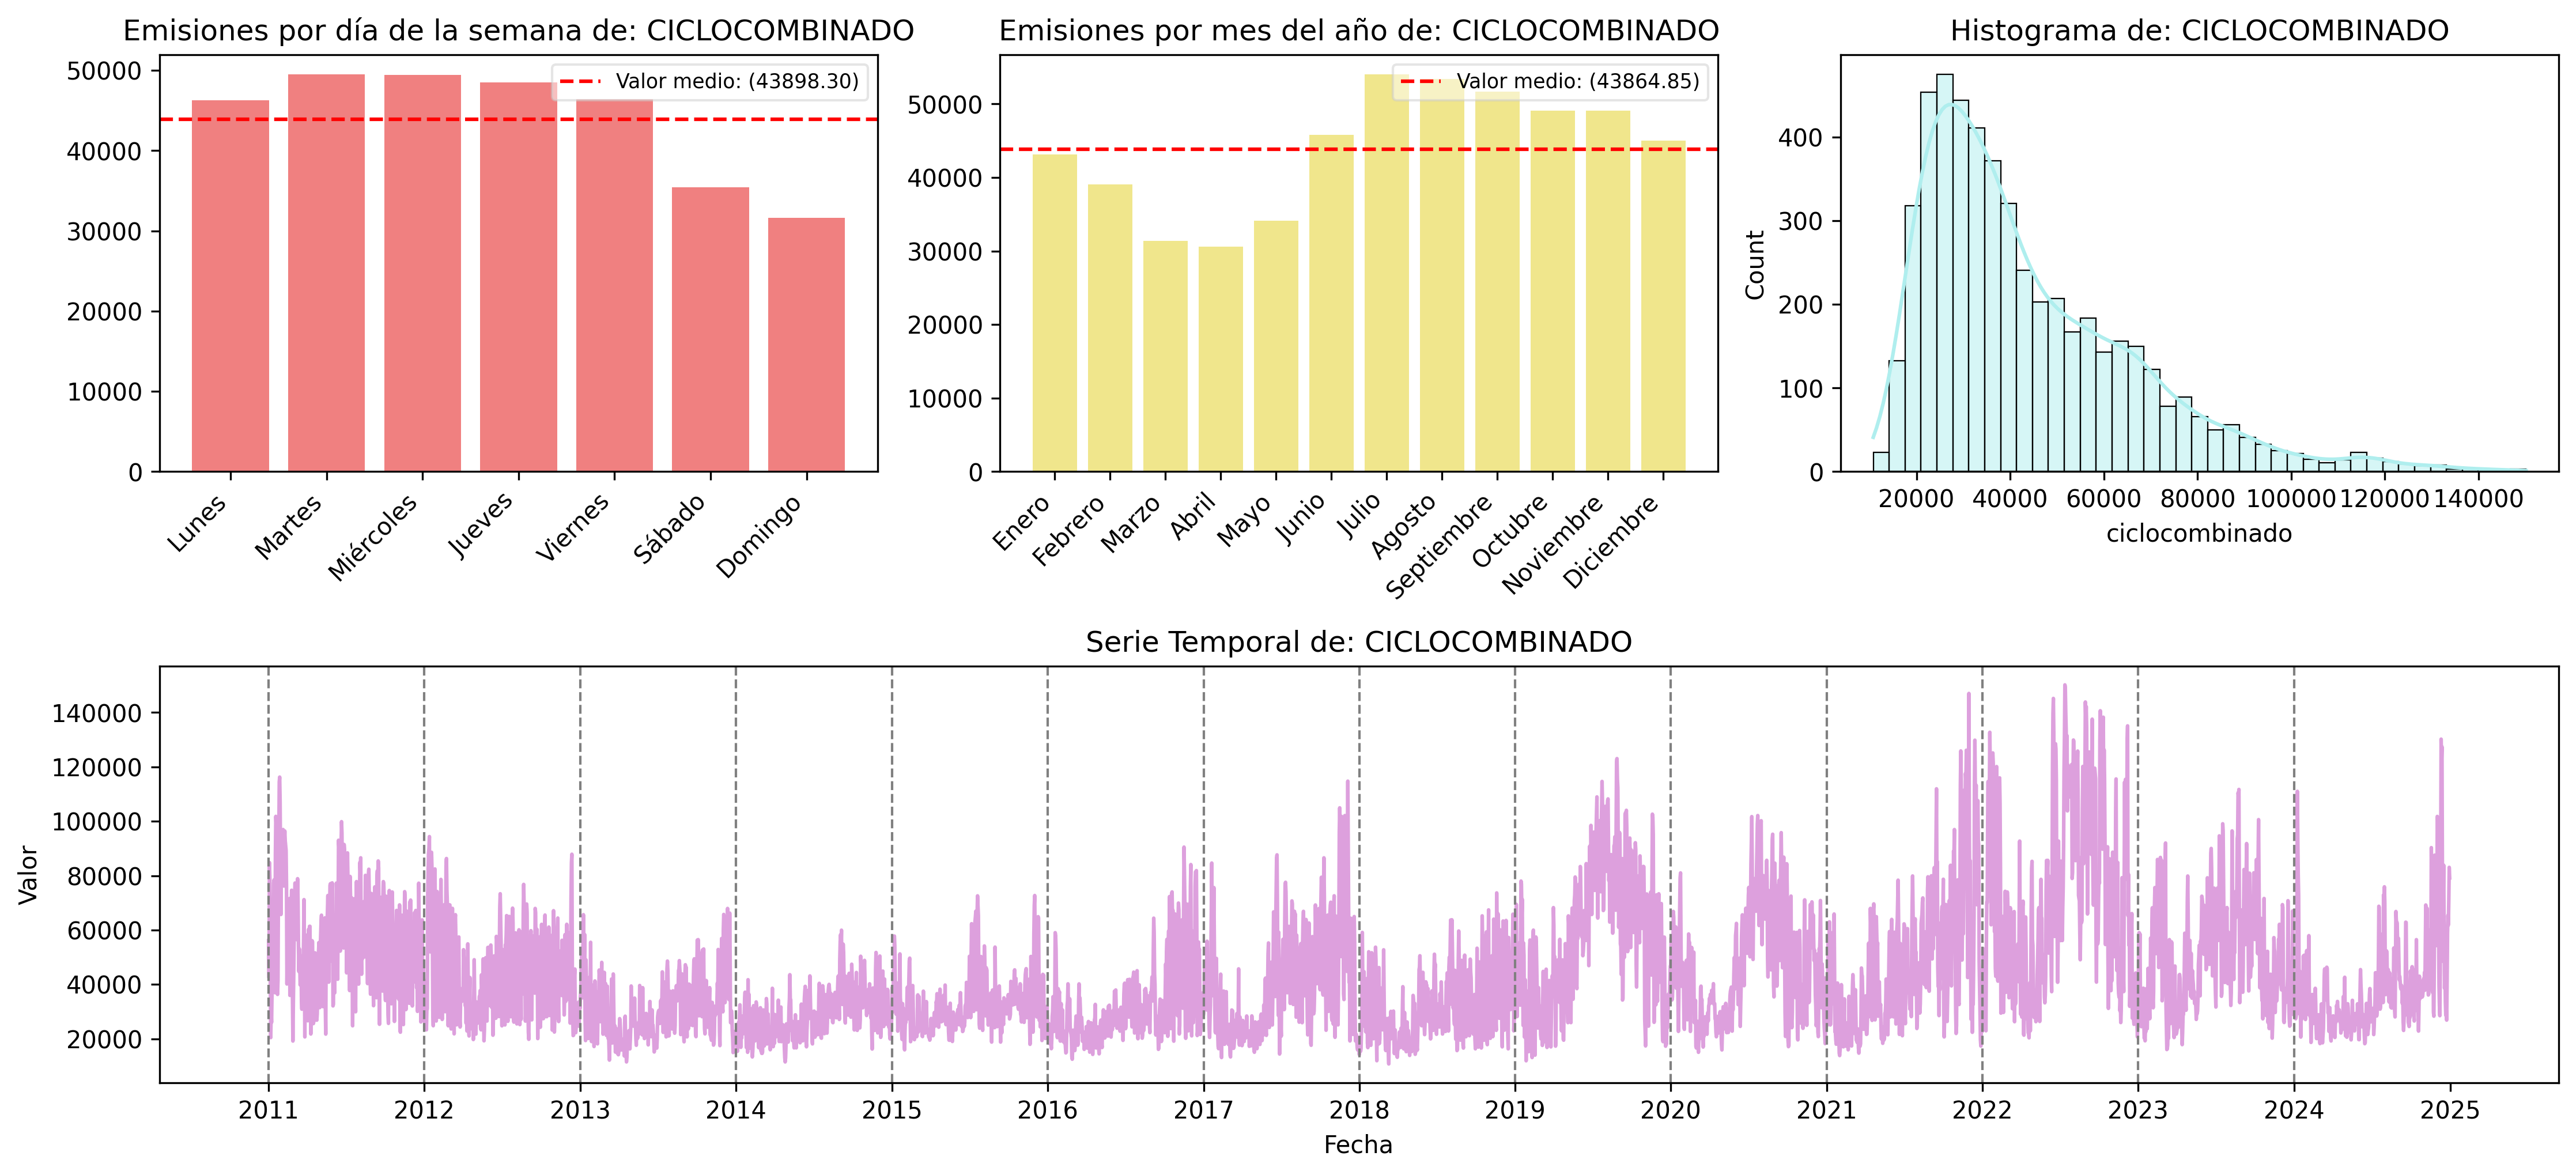

In [17]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','ciclocombinado')

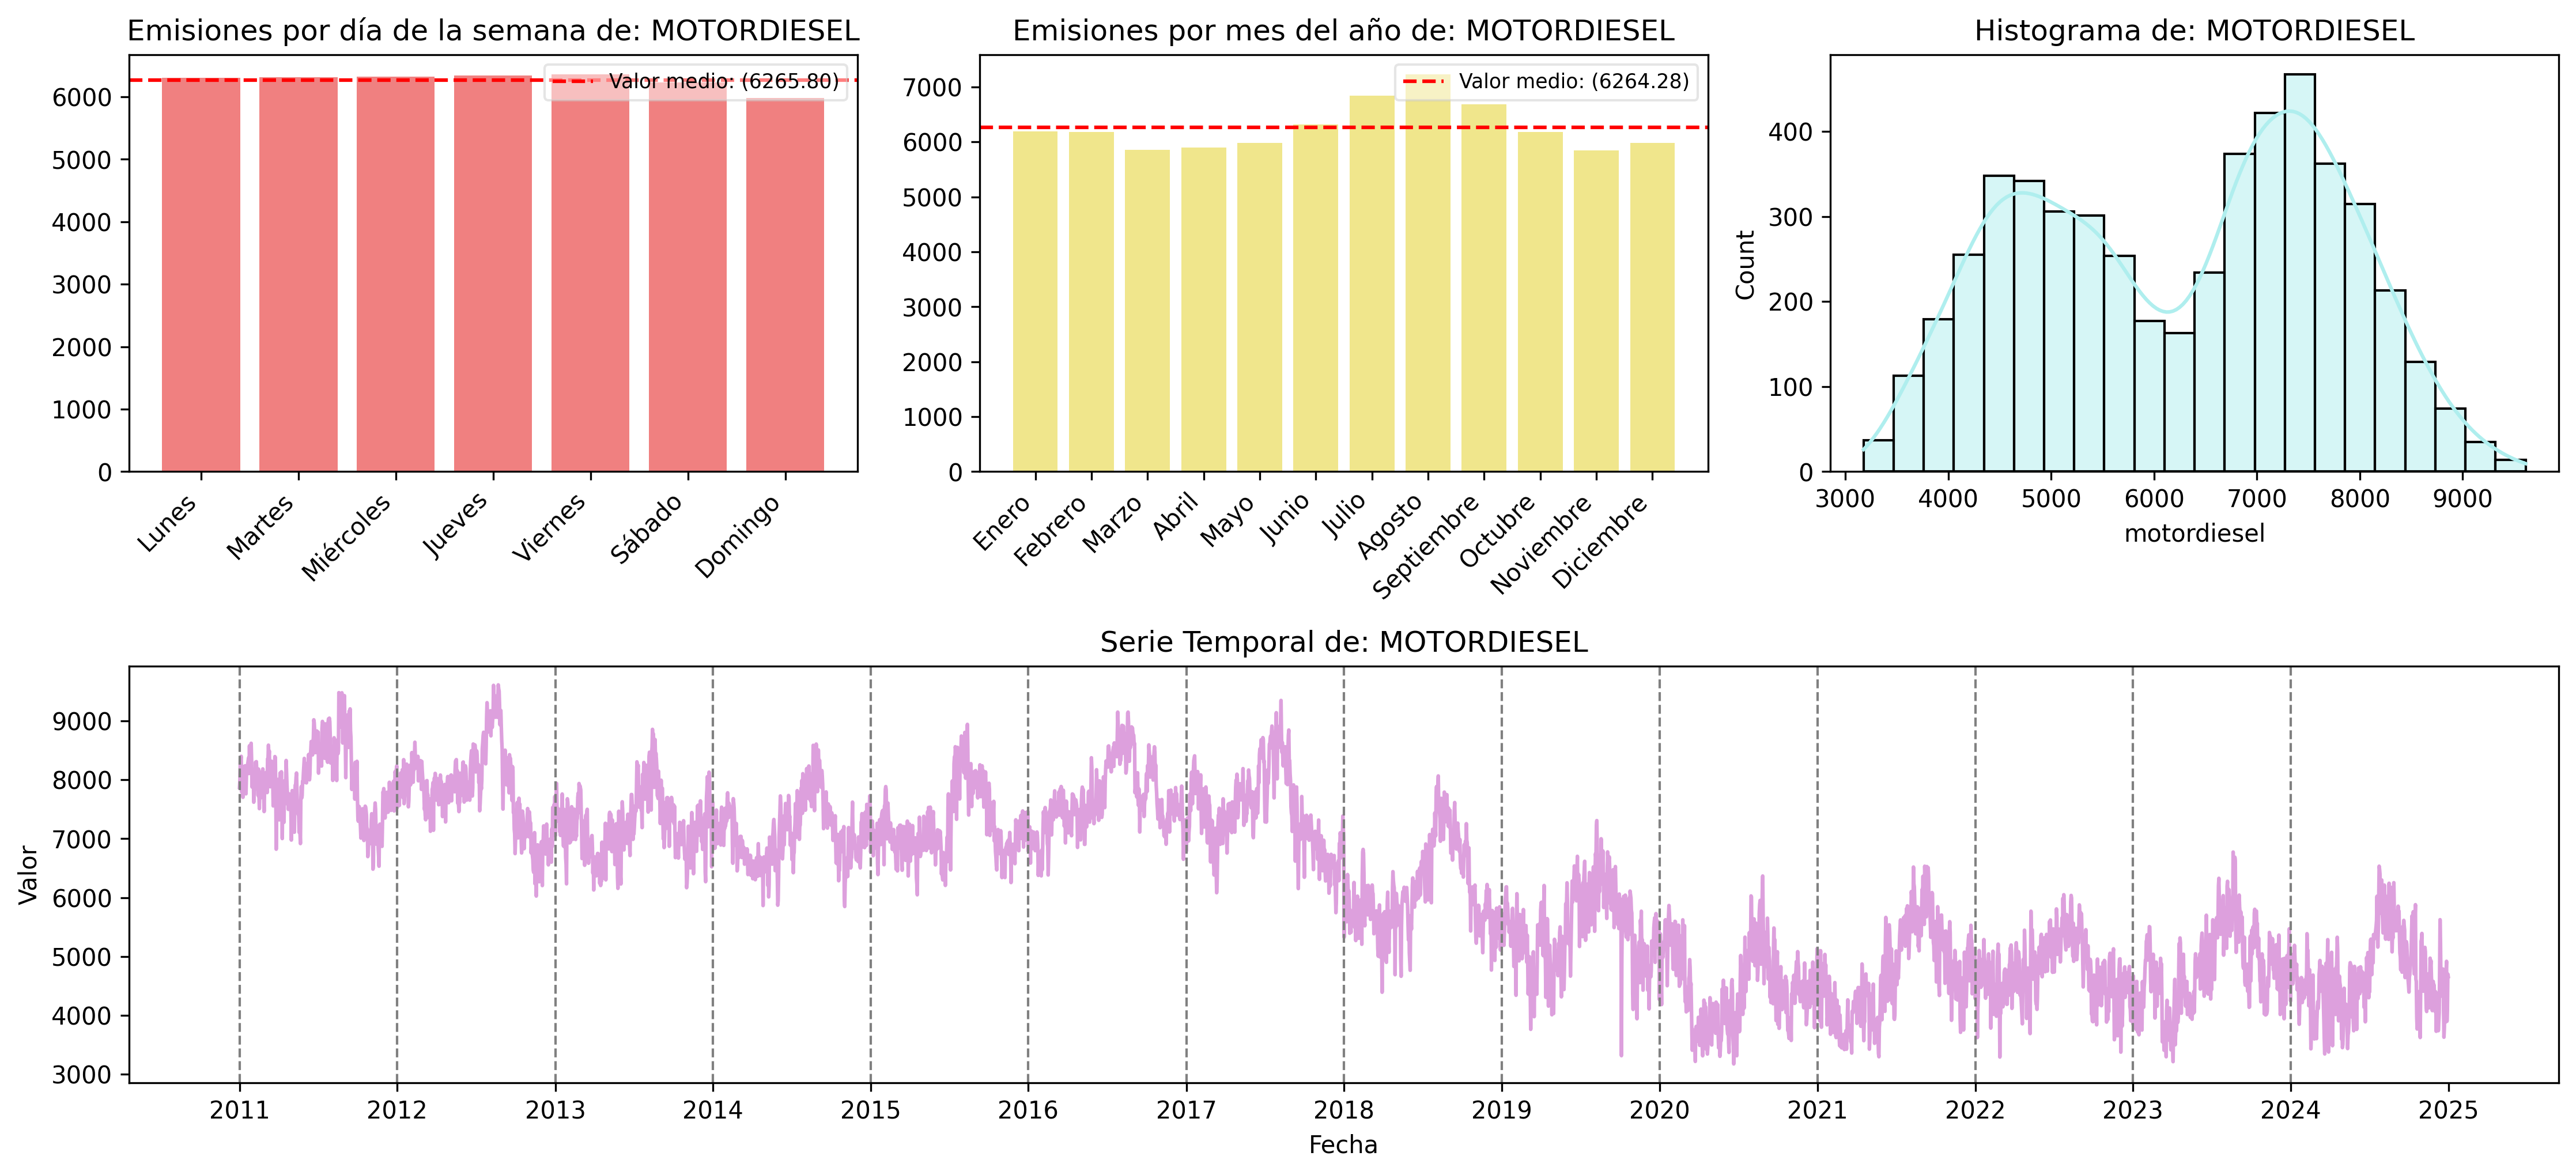

In [18]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','motordiesel')

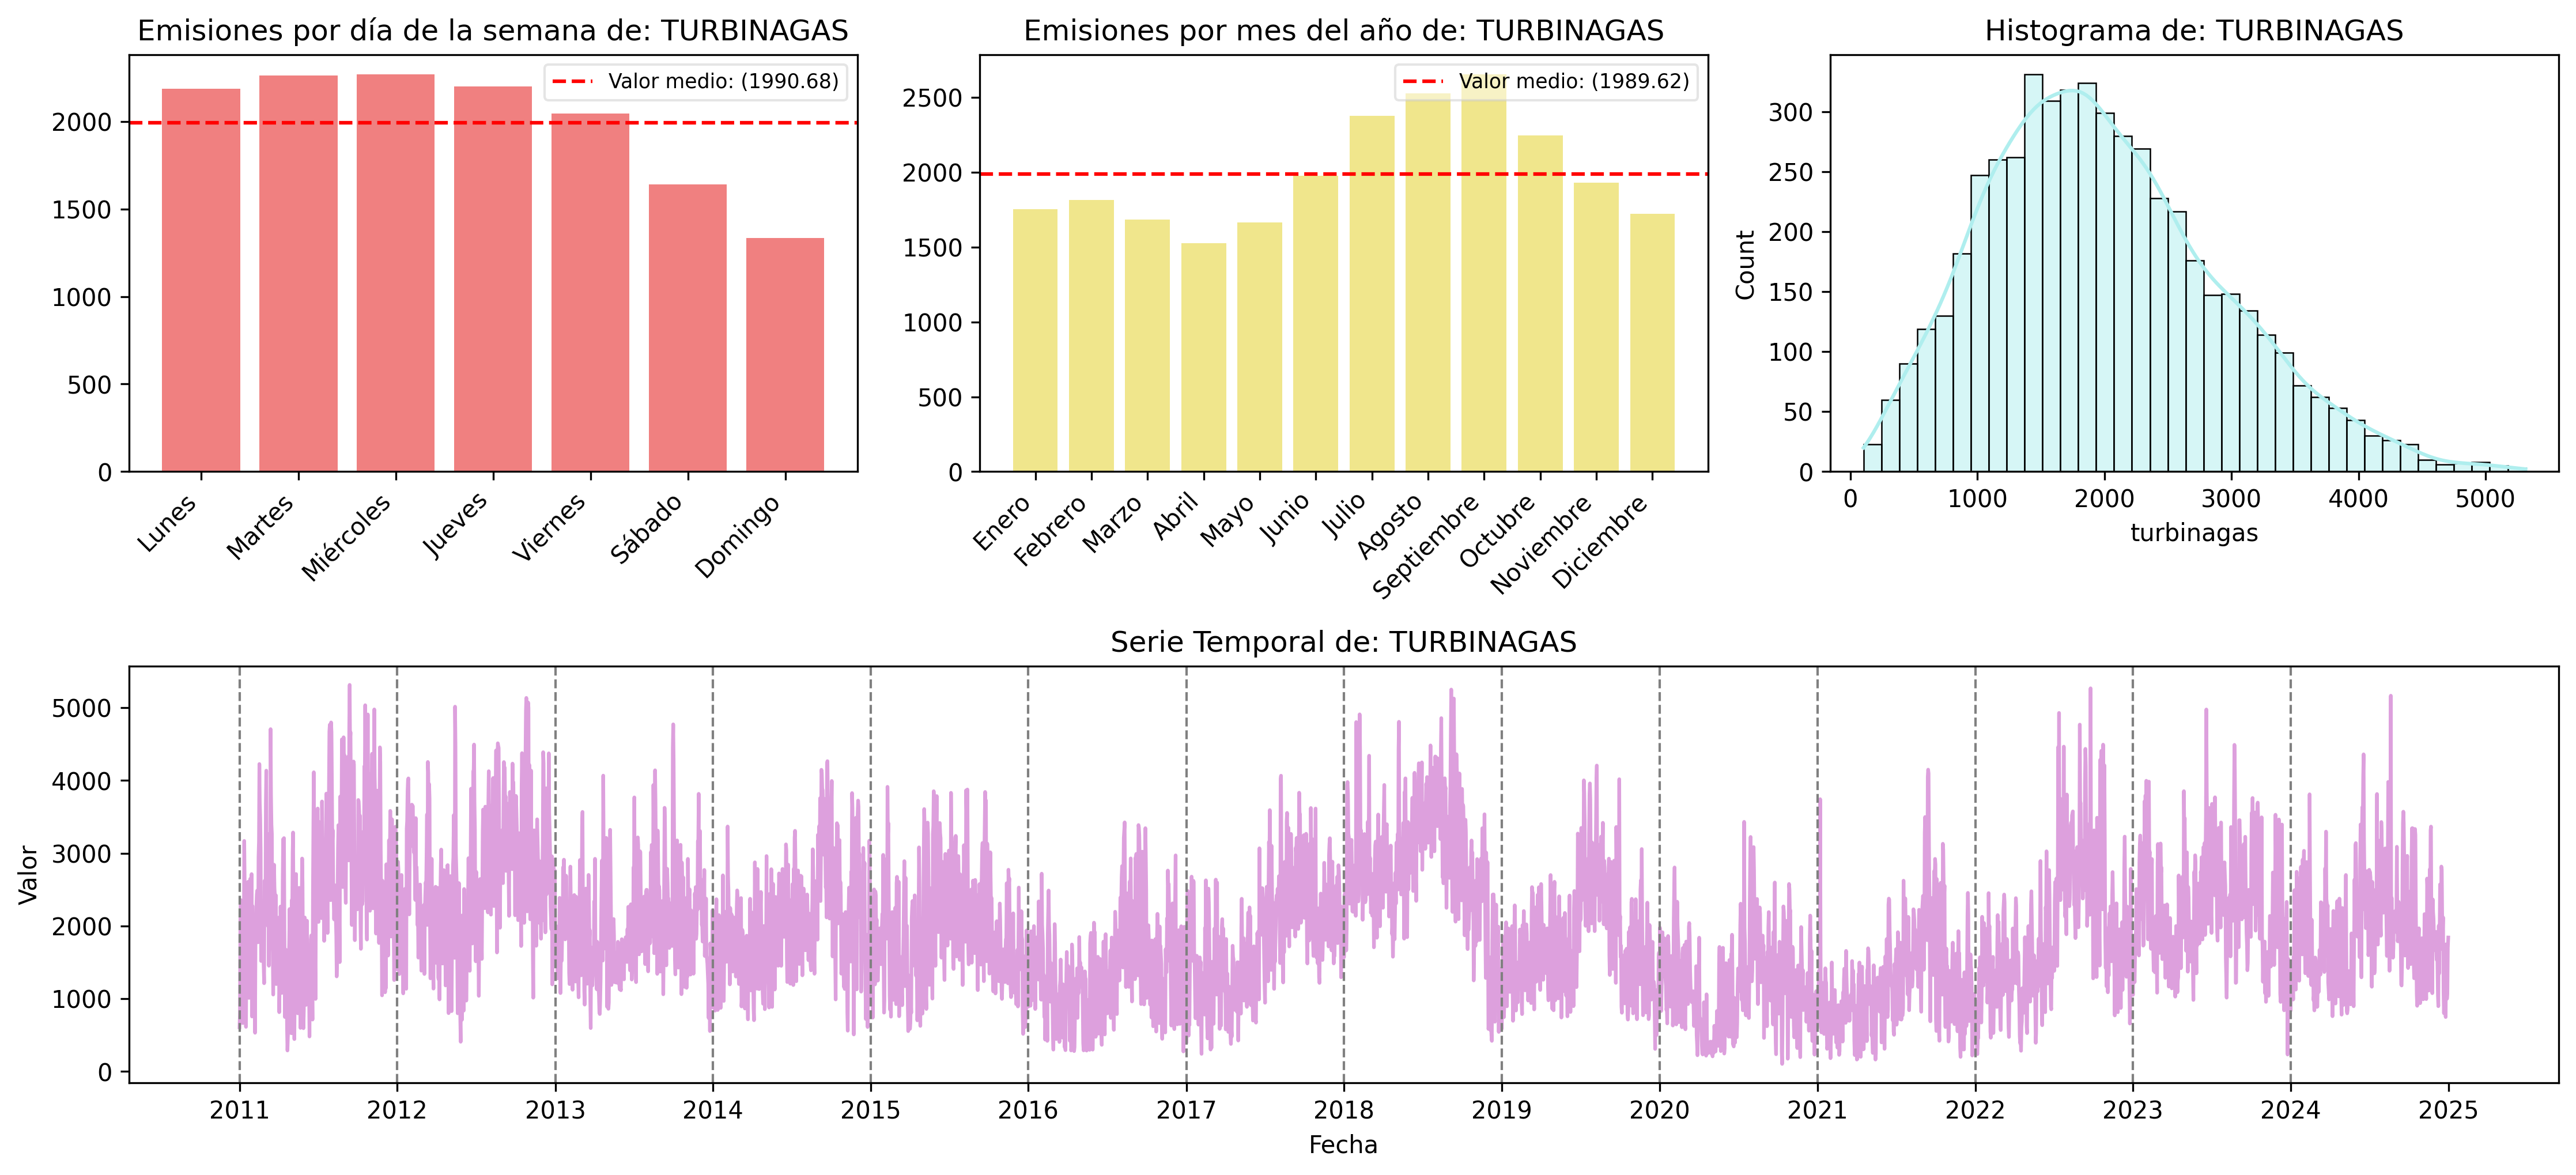

In [19]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','turbinagas')

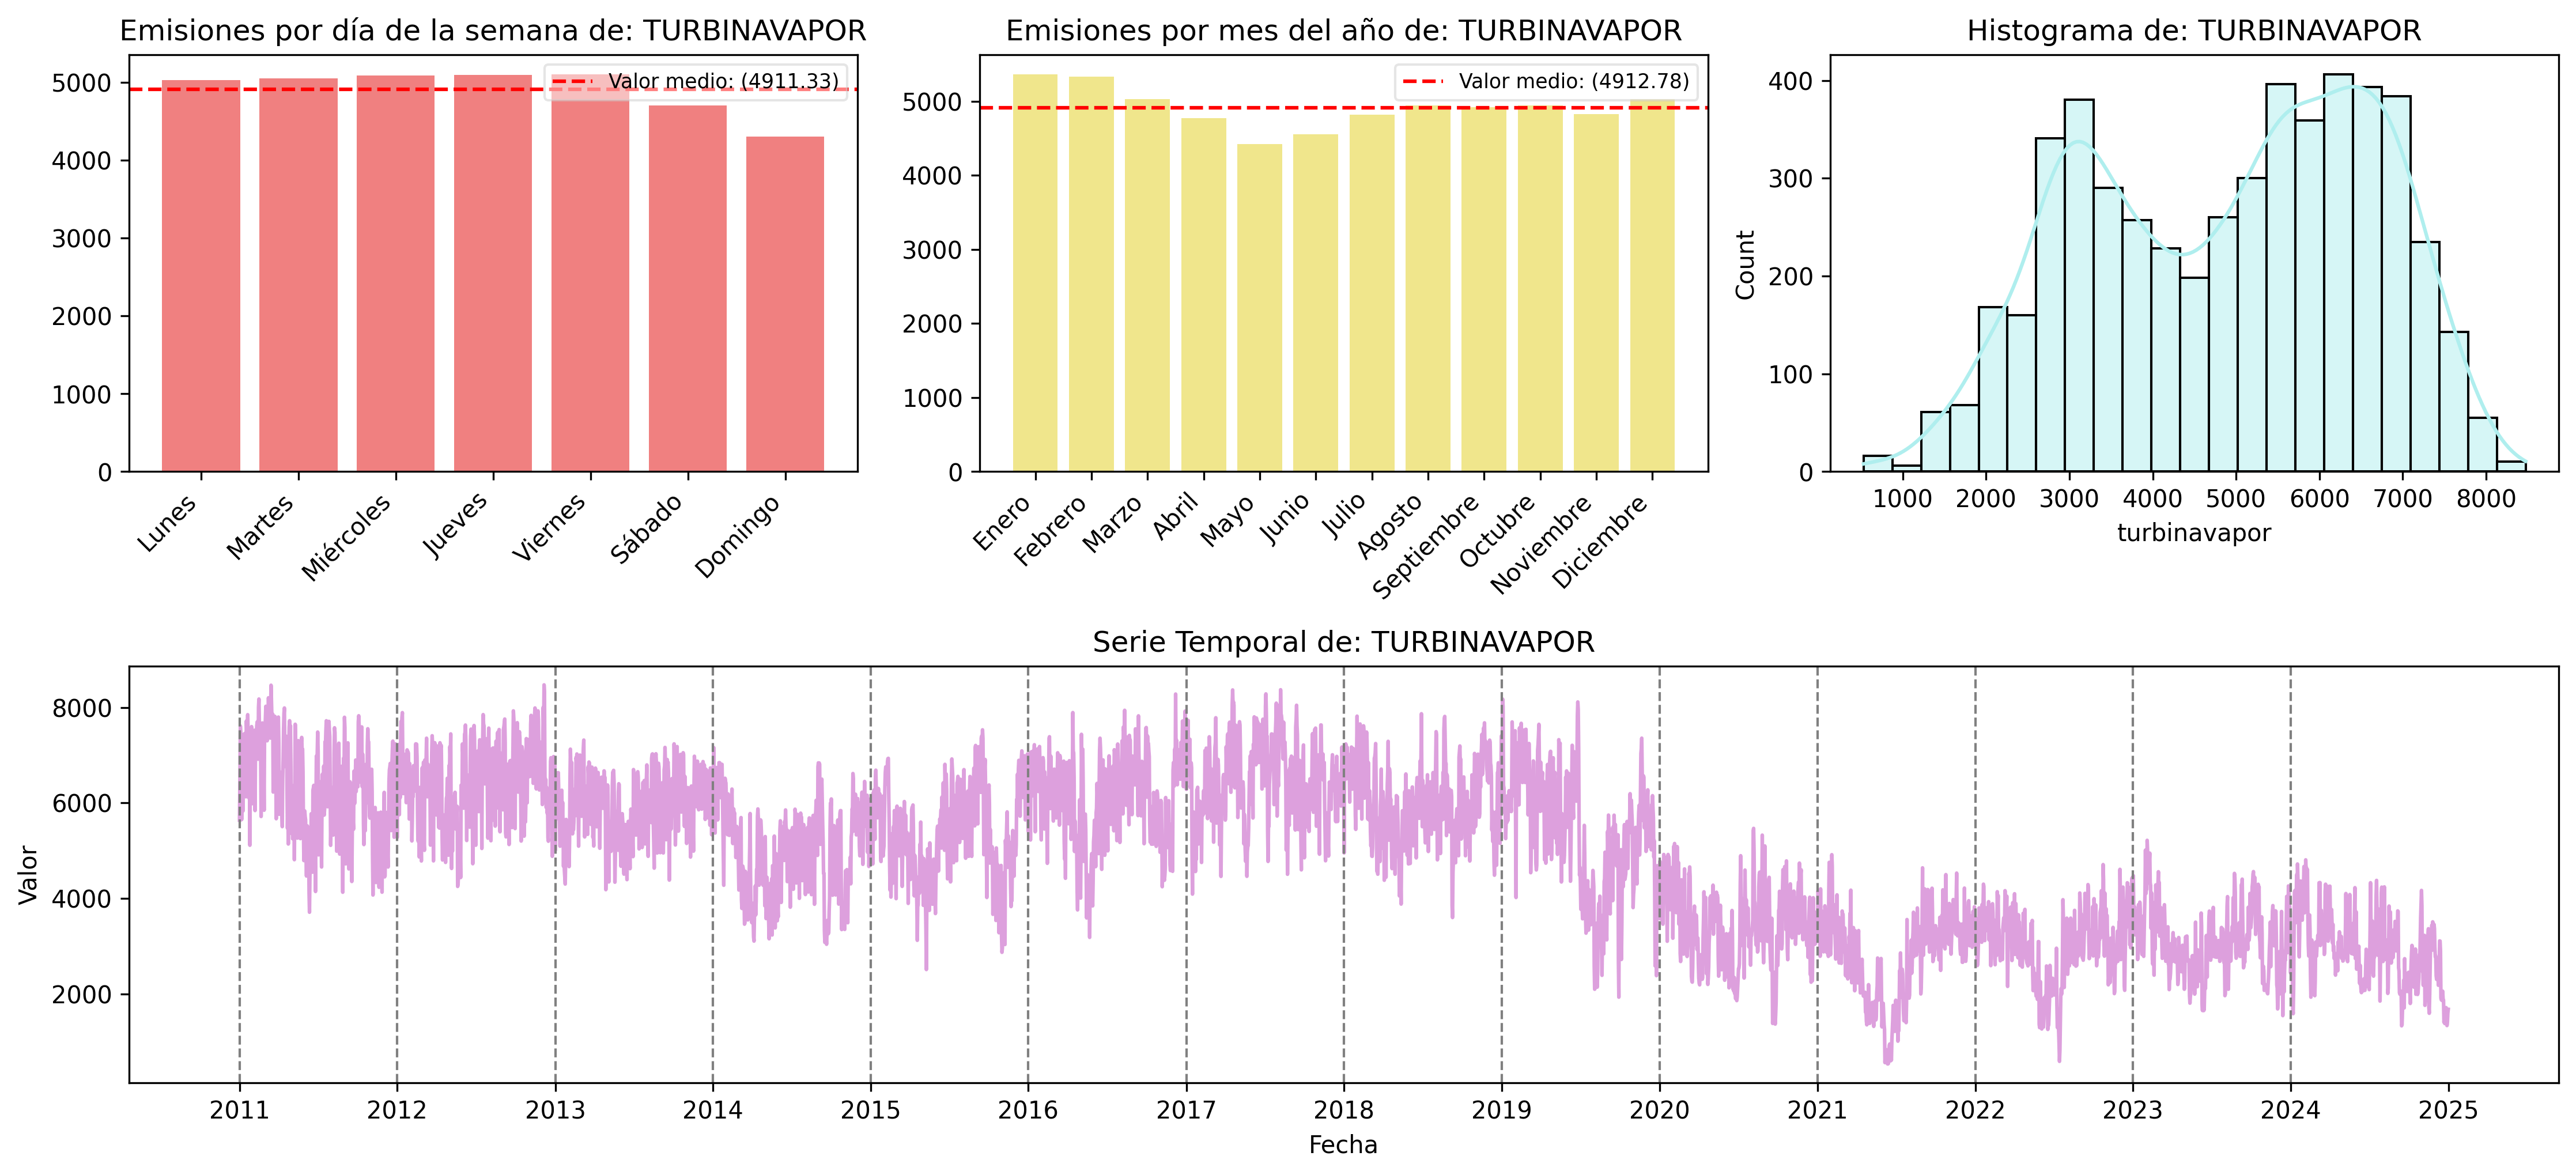

In [20]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','turbinavapor')

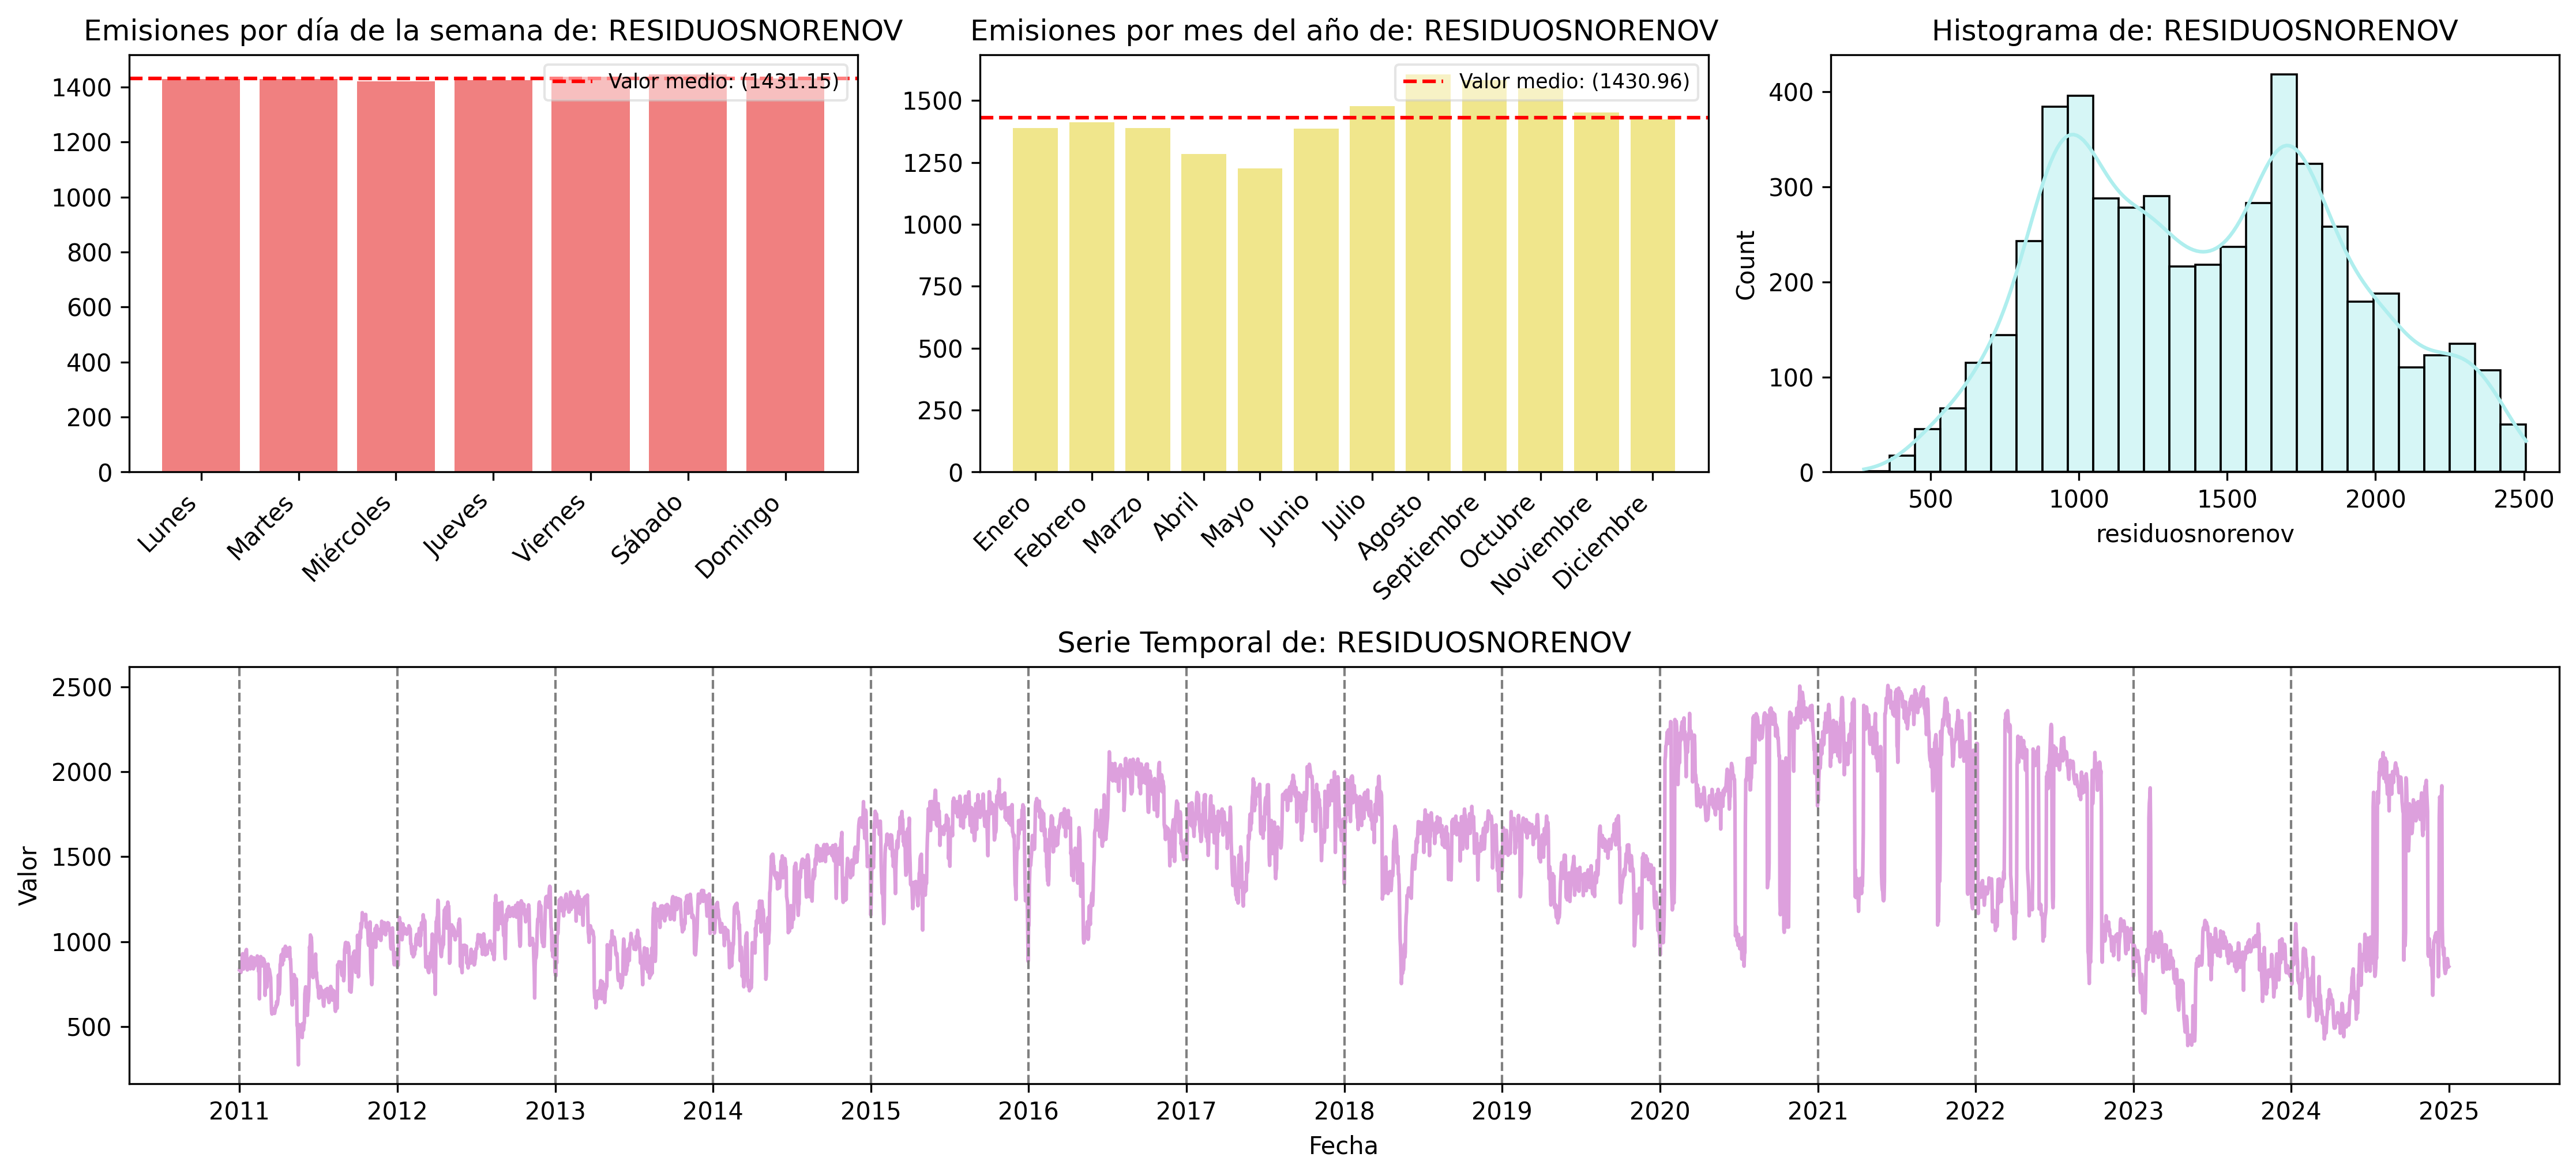

In [21]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','residuosnorenov')

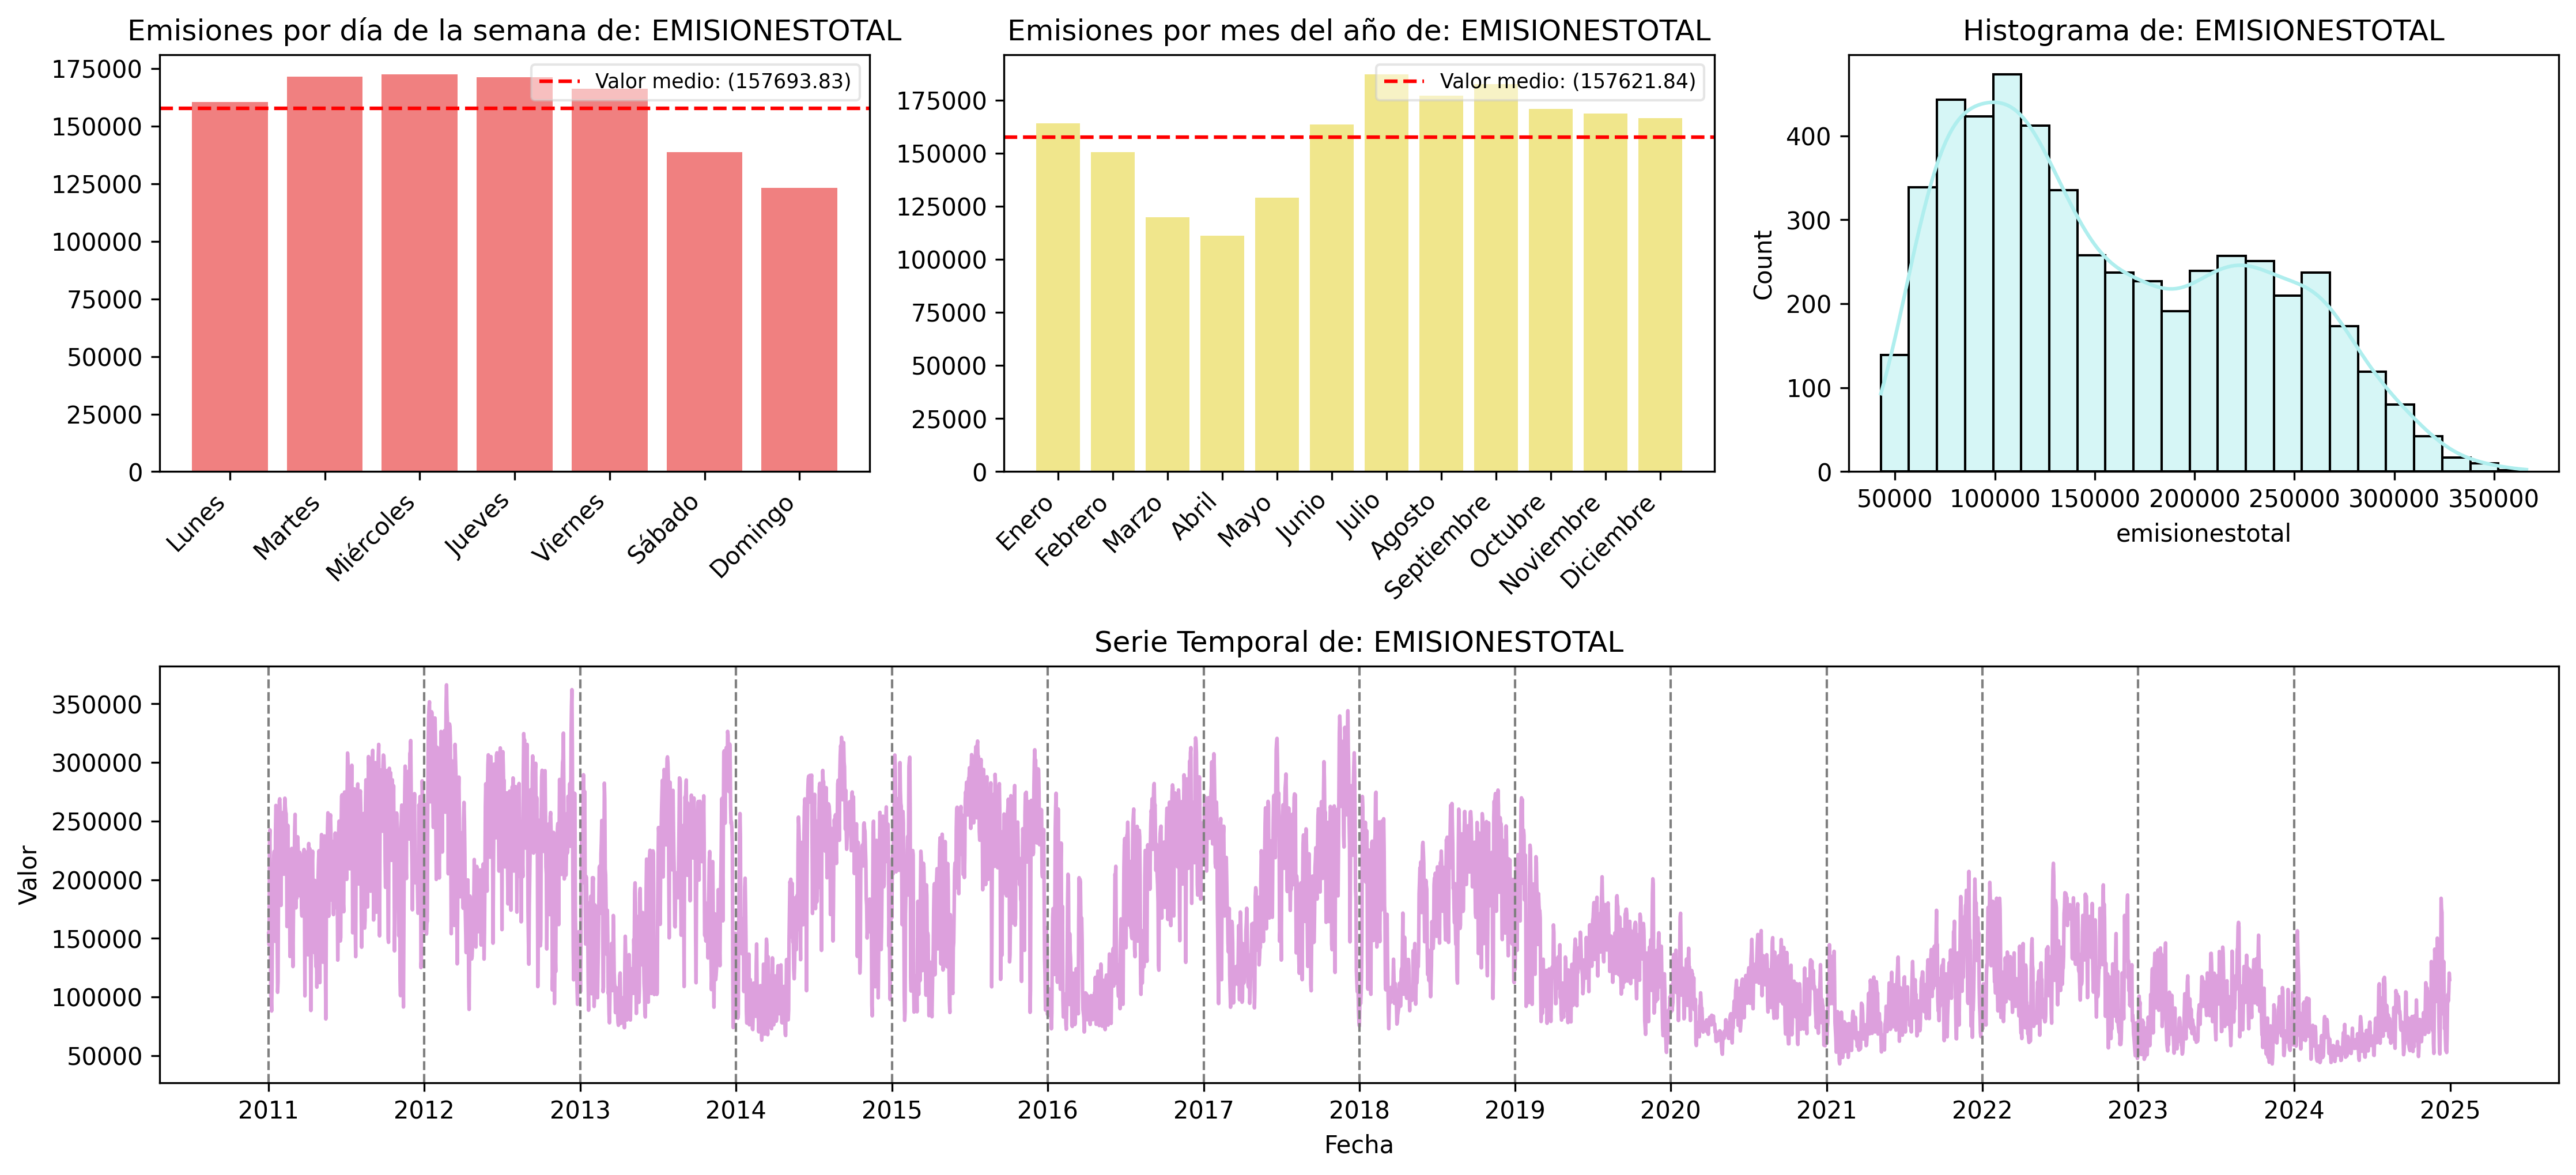

In [22]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','emisionestotal')

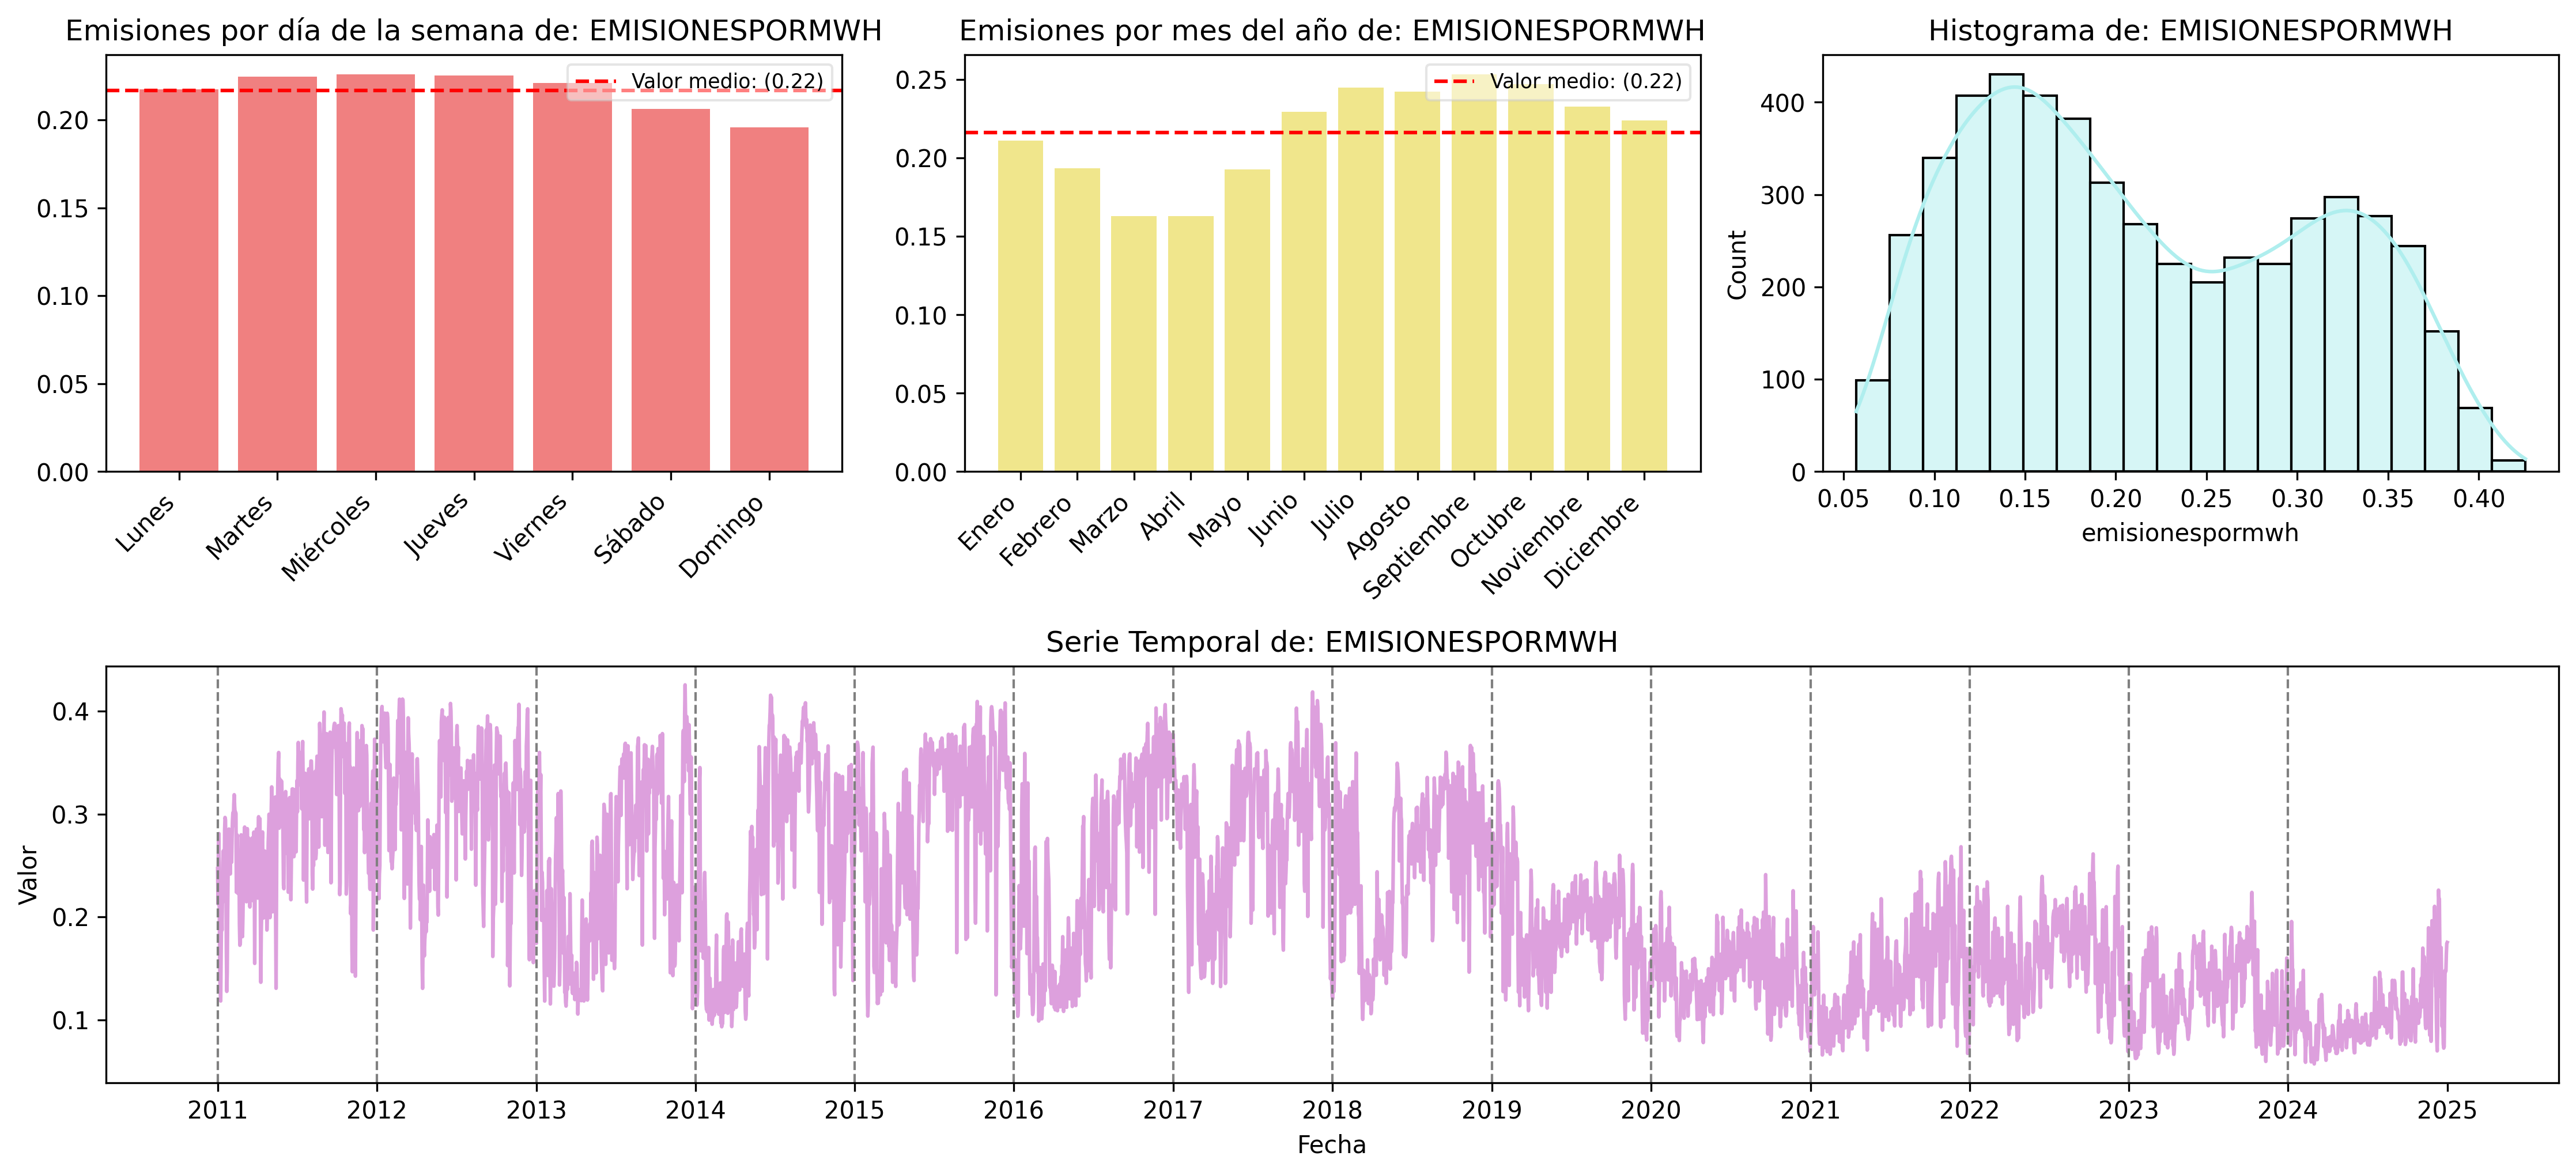

In [23]:
generarGraficasDistribucion_2filas_gen(dataframeemisiones,'fecha','Mes','DiaSemana','emisionespormwh')

Con esto damos por finalizada la parte del análisis de los datos de emisiones